# Задача классификации изображений

In [1]:
import cv2
import numpy as np
import tqdm.notebook as tq

import pickle

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchsummary

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

from model import ClassificationModel

from dataset import CustomDataset
from utils import calcAccuracy

## Формирование датасета

In [2]:
dataset = CustomDataset()

## Разбиение на тренировочную и тестовую выборку с коэффициентом 0.3

In [3]:
dataset = CustomDataset()
dataset_train, dataset_test = train_test_split(dataset, test_size=0.3)

data_loader_train = DataLoader(dataset_train, batch_size=16, shuffle=True)
data_loader_test = DataLoader(dataset_test, batch_size=16, shuffle=True)

print('Train data length:', len(data_loader_train))
print('Test data length:', len(data_loader_test))

Train data length: 284
Test data length: 122


## Вывод примеров тренировочных данных

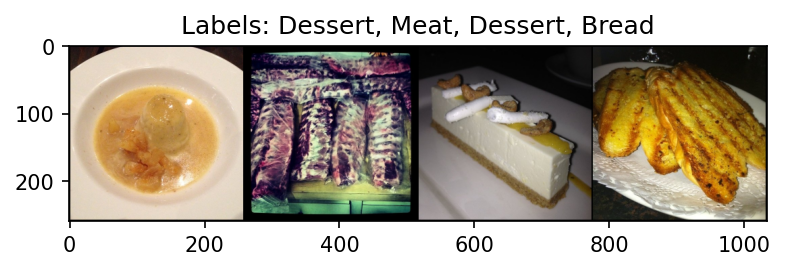

In [4]:
train_features, train_labels = next(iter(data_loader_train))
train_features = dataset.getImgsTensors(train_features)[:4]

plt.title('Labels: ' + ', '.join([dataset.getName(i) for i in train_labels[:4]]))
gridImgs = torchvision.utils.make_grid(train_features)
plt.imshow(cv2.cvtColor(gridImgs.permute(1, 2, 0).numpy() / 255, cv2.COLOR_BGR2RGB))
plt.show()

## Определение доступного устройства для обучения

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Создание модели и вывод информации о ней

In [6]:
model = ClassificationModel().to(device)
torchsummary.summary(model, (3, 256, 256))

Model created!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 48, 126, 126]           3,648
              ReLU-2         [-1, 48, 126, 126]               0
         MaxPool2d-3           [-1, 48, 62, 62]               0
            Conv2d-4          [-1, 128, 62, 62]         153,728
              ReLU-5          [-1, 128, 62, 62]               0
         MaxPool2d-6          [-1, 128, 30, 30]               0
            Conv2d-7          [-1, 256, 30, 30]         295,168
              ReLU-8          [-1, 256, 30, 30]               0
            Conv2d-9          [-1, 256, 30, 30]         590,080
             ReLU-10          [-1, 256, 30, 30]               0
           Conv2d-11          [-1, 128, 30, 30]         295,040
             ReLU-12          [-1, 128, 30, 30]               0
        MaxPool2d-13          [-1, 128, 14, 14]               0
           Linear-14    

## Определение оптимизатора и функции ошибки

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Обучение модели и подсчет ошибки для тестовой выборки

<IPython.core.display.Javascript object>


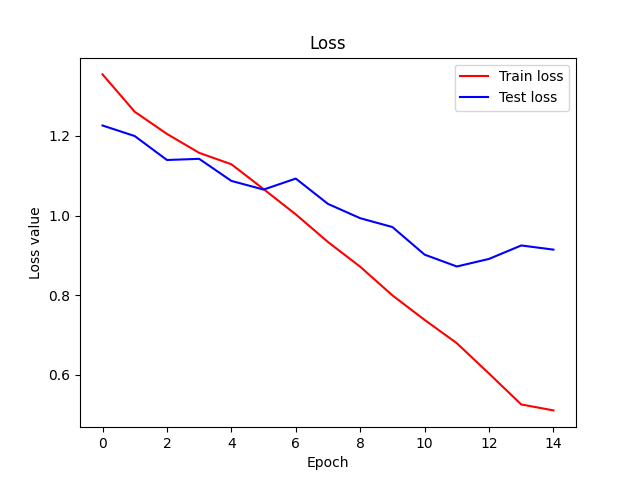

<IPython.core.display.Javascript object>


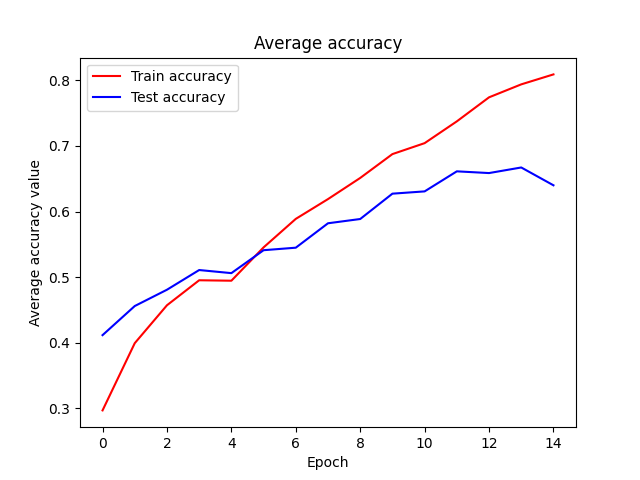

[1] Training batches:   0%|          | 0/284 [00:00<?, ?it/s]

[1] Train loss: 384.5573927164 1.3540753265
[1] Train accuracy:
	Bread: 0.40
	Dessert: 0.24
	Meat: 0.43
	Soup: 0.11
[1] Train average accuracy: 0.30


[1] Testing batches:   0%|          | 0/122 [00:00<?, ?it/s]

[1] Test loss: 149.5587946773 1.2258917596
[1] Test accuracy:
	Bread: 0.54
	Dessert: 0.01
	Meat: 0.83
	Soup: 0.27
[1] Test average accuracy: 0.41
This is new best model
------------------------------


[2] Training batches:   0%|          | 0/284 [00:00<?, ?it/s]

[2] Train loss: 357.9127141833 1.2602560359
[2] Train accuracy:
	Bread: 0.45
	Dessert: 0.30
	Meat: 0.52
	Soup: 0.32
[2] Train average accuracy: 0.40


[2] Testing batches:   0%|          | 0/122 [00:00<?, ?it/s]

[2] Test loss: 146.3239028454 1.1993762528
[2] Test accuracy:
	Bread: 0.73
	Dessert: 0.28
	Meat: 0.51
	Soup: 0.30
[2] Test average accuracy: 0.46
This is new best model
------------------------------


[3] Training batches:   0%|          | 0/284 [00:00<?, ?it/s]

[3] Train loss: 342.1538882256 1.2047672121
[3] Train accuracy:
	Bread: 0.47
	Dessert: 0.38
	Meat: 0.58
	Soup: 0.40
[3] Train average accuracy: 0.46


[3] Testing batches:   0%|          | 0/122 [00:00<?, ?it/s]

[3] Test loss: 138.9978482127 1.1393266247
[3] Test accuracy:
	Bread: 0.35
	Dessert: 0.18
	Meat: 0.61
	Soup: 0.78
[3] Test average accuracy: 0.48
This is new best model
------------------------------


[4] Training batches:   0%|          | 0/284 [00:00<?, ?it/s]

[4] Train loss: 328.6563621163 1.1572407117
[4] Train accuracy:
	Bread: 0.50
	Dessert: 0.36
	Meat: 0.65
	Soup: 0.46
[4] Train average accuracy: 0.50


[4] Testing batches:   0%|          | 0/122 [00:00<?, ?it/s]

[4] Test loss: 139.3536657691 1.1422431620
[4] Test accuracy:
	Bread: 0.35
	Dessert: 0.45
	Meat: 0.81
	Soup: 0.43
[4] Test average accuracy: 0.51
This is new best model
------------------------------


[5] Training batches:   0%|          | 0/284 [00:00<?, ?it/s]

[5] Train loss: 320.5411145091 1.1286658962
[5] Train accuracy:
	Bread: 0.45
	Dessert: 0.40
	Meat: 0.63
	Soup: 0.50
[5] Train average accuracy: 0.49


[5] Testing batches:   0%|          | 0/122 [00:00<?, ?it/s]

[5] Test loss: 132.6001085639 1.0868861358
[5] Test accuracy:
	Bread: 0.80
	Dessert: 0.16
	Meat: 0.77
	Soup: 0.30
[5] Test average accuracy: 0.51
------------------------------


[6] Training batches:   0%|          | 0/284 [00:00<?, ?it/s]

[6] Train loss: 302.8376118541 1.0663296192
[6] Train accuracy:
	Bread: 0.52
	Dessert: 0.42
	Meat: 0.66
	Soup: 0.58
[6] Train average accuracy: 0.55


[6] Testing batches:   0%|          | 0/122 [00:00<?, ?it/s]

[6] Test loss: 129.9490684867 1.0651562991
[6] Test accuracy:
	Bread: 0.67
	Dessert: 0.34
	Meat: 0.84
	Soup: 0.32
[6] Test average accuracy: 0.54
This is new best model
------------------------------


[7] Training batches:   0%|          | 0/284 [00:00<?, ?it/s]

[7] Train loss: 284.8103663921 1.0028534028
[7] Train accuracy:
	Bread: 0.61
	Dessert: 0.45
	Meat: 0.68
	Soup: 0.62
[7] Train average accuracy: 0.59


[7] Testing batches:   0%|          | 0/122 [00:00<?, ?it/s]

[7] Test loss: 133.3111516237 1.0927143576
[7] Test accuracy:
	Bread: 0.68
	Dessert: 0.29
	Meat: 0.83
	Soup: 0.37
[7] Test average accuracy: 0.54
This is new best model
------------------------------


[8] Training batches:   0%|          | 0/284 [00:00<?, ?it/s]

[8] Train loss: 265.1271340847 0.9335462468
[8] Train accuracy:
	Bread: 0.62
	Dessert: 0.47
	Meat: 0.67
	Soup: 0.71
[8] Train average accuracy: 0.62


[8] Testing batches:   0%|          | 0/122 [00:00<?, ?it/s]

[8] Test loss: 125.5558842719 1.0291465924
[8] Test accuracy:
	Bread: 0.87
	Dessert: 0.39
	Meat: 0.51
	Soup: 0.56
[8] Test average accuracy: 0.58
This is new best model
------------------------------


[9] Training batches:   0%|          | 0/284 [00:00<?, ?it/s]

[9] Train loss: 247.5307071805 0.8715869971
[9] Train accuracy:
	Bread: 0.65
	Dessert: 0.50
	Meat: 0.72
	Soup: 0.73
[9] Train average accuracy: 0.65


[9] Testing batches:   0%|          | 0/122 [00:00<?, ?it/s]

[9] Test loss: 121.1832135320 0.9933050290
[9] Test accuracy:
	Bread: 0.84
	Dessert: 0.11
	Meat: 0.74
	Soup: 0.67
[9] Test average accuracy: 0.59
This is new best model
------------------------------


[10] Training batches:   0%|          | 0/284 [00:00<?, ?it/s]

[10] Train loss: 227.1284381747 0.7997480217
[10] Train accuracy:
	Bread: 0.69
	Dessert: 0.53
	Meat: 0.76
	Soup: 0.77
[10] Train average accuracy: 0.69


[10] Testing batches:   0%|          | 0/122 [00:00<?, ?it/s]

[10] Test loss: 118.4761814475 0.9711162414
[10] Test accuracy:
	Bread: 0.69
	Dessert: 0.55
	Meat: 0.49
	Soup: 0.78
[10] Test average accuracy: 0.63
This is new best model
------------------------------


[11] Training batches:   0%|          | 0/284 [00:00<?, ?it/s]

[11] Train loss: 209.6396092176 0.7381676381
[11] Train accuracy:
	Bread: 0.73
	Dessert: 0.54
	Meat: 0.75
	Soup: 0.79
[11] Train average accuracy: 0.70


[11] Testing batches:   0%|          | 0/122 [00:00<?, ?it/s]

[11] Test loss: 110.0336203873 0.9019149212
[11] Test accuracy:
	Bread: 0.81
	Dessert: 0.38
	Meat: 0.60
	Soup: 0.73
[11] Test average accuracy: 0.63
This is new best model
------------------------------


[12] Training batches:   0%|          | 0/284 [00:00<?, ?it/s]

[12] Train loss: 193.0329745859 0.6796935725
[12] Train accuracy:
	Bread: 0.76
	Dessert: 0.60
	Meat: 0.77
	Soup: 0.82
[12] Train average accuracy: 0.74


[12] Testing batches:   0%|          | 0/122 [00:00<?, ?it/s]

[12] Test loss: 106.4054841101 0.8721760993
[12] Test accuracy:
	Bread: 0.64
	Dessert: 0.54
	Meat: 0.75
	Soup: 0.71
[12] Test average accuracy: 0.66
This is new best model
------------------------------


[13] Training batches:   0%|          | 0/284 [00:00<?, ?it/s]

[13] Train loss: 171.4062365592 0.6035430865
[13] Train accuracy:
	Bread: 0.78
	Dessert: 0.66
	Meat: 0.81
	Soup: 0.85
[13] Train average accuracy: 0.77


[13] Testing batches:   0%|          | 0/122 [00:00<?, ?it/s]

[13] Test loss: 108.7269138694 0.8912042120
[13] Test accuracy:
	Bread: 0.77
	Dessert: 0.43
	Meat: 0.73
	Soup: 0.70
[13] Test average accuracy: 0.66
------------------------------


[14] Training batches:   0%|          | 0/284 [00:00<?, ?it/s]

[14] Train loss: 149.4058189318 0.5260768272
[14] Train accuracy:
	Bread: 0.83
	Dessert: 0.66
	Meat: 0.83
	Soup: 0.86
[14] Train average accuracy: 0.79


[14] Testing batches:   0%|          | 0/122 [00:00<?, ?it/s]

[14] Test loss: 112.8435024023 0.9249467410
[14] Test accuracy:
	Bread: 0.68
	Dessert: 0.48
	Meat: 0.74
	Soup: 0.76
[14] Test average accuracy: 0.67
This is new best model
------------------------------


[15] Training batches:   0%|          | 0/284 [00:00<?, ?it/s]

[15] Train loss: 145.1681552753 0.5111554763
[15] Train accuracy:
	Bread: 0.82
	Dessert: 0.71
	Meat: 0.83
	Soup: 0.88
[15] Train average accuracy: 0.81


[15] Testing batches:   0%|          | 0/122 [00:00<?, ?it/s]

[15] Test loss: 111.5659512281 0.9144750101
[15] Test accuracy:
	Bread: 0.73
	Dessert: 0.44
	Meat: 0.63
	Soup: 0.75
[15] Test average accuracy: 0.64
------------------------------
Тренировка завершена, наилучшая средняя точность: 0.6671864573536992


In [8]:
%matplotlib notebook

axis = [None, None]

fig1, axis[0] = plt.subplots(1, 1)
fig2, axis[1] = plt.subplots(1, 1)

graph_epochs = []
graph_train_loss = []
graph_test_loss = []

graph_train_accuracy = []
graph_test_accuracy = []

axis[0].relim() 
axis[0].autoscale_view(True,True,True)
axis[0].set_title('Loss')
axis[0].set_ylabel('Loss value')
axis[0].set_xlabel('Epoch')

axis[1].relim() 
axis[1].autoscale_view(True,True,True)
axis[1].set_title('Average accuracy')
axis[1].set_ylabel('Average accuracy value')
axis[1].set_xlabel('Epoch')

plt.show(block=False)

best_loss = np.inf
best_accuracy = 0.0

for epoch in range(15):
    model.train()
    train_loss = 0.0
    
    predictList = []
    targetList = []

    for i, data in enumerate(tq.tqdm(data_loader_train, desc='[%d] Training batches' % (epoch + 1)), 0):
        # получаем вводные данные
        inputs, labels = data
        labels = labels.to(device)
        inputs = dataset.getImgsTensors(inputs).to(device)

        # обнуляем параметр gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, torch.max(labels, 1)[0])
        loss.backward()

        optimizer.step()

        train_loss += loss.item()
        
        predictList += torch.max(outputs, 1)[1].tolist()
        targetList += labels.squeeze(1).tolist()
        
    accuracyDict = calcAccuracy(targetList, predictList)

    print('[%d] Train loss: %.10f %.10f' % (epoch + 1, train_loss, train_loss / len(data_loader_train)))
    print('[%d] Train accuracy:' % (epoch + 1))

    print(*[f'\t{dataset.getName(i)}: {accuracyDict[i]:.2f}' for i in accuracyDict.keys()], sep='\n')

    train_accuracy = sum([accuracyDict[i] for i in accuracyDict.keys()]) / len(accuracyDict.keys())
    print('[%d] Train average accuracy: %.2f' % (epoch + 1, train_accuracy))
    
    graph_train_accuracy.append(train_accuracy)

    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0

    with torch.no_grad():
        predictList = []
        targetList = []

        for i, data in enumerate(tq.tqdm(data_loader_test, desc='[%d] Testing batches' % (epoch + 1)), 0):
            # получаем вводные данные
            inputs, labels = data
            labels = labels.to(device)
            inputs = dataset.getImgsTensors(inputs).to(device)

            outputs = model(inputs)

            loss = criterion(outputs, torch.max(labels, 1)[0])

            test_loss += loss.item()
            
            predictList += torch.max(outputs, 1)[1].tolist()
            targetList += labels.squeeze(1).tolist()

        accuracyDict = calcAccuracy(targetList, predictList)

    print('[%d] Test loss: %.10f %.10f' % (epoch + 1, test_loss, test_loss / len(data_loader_test)))
    print('[%d] Test accuracy:' % (epoch + 1))

    print(*[f'\t{dataset.getName(i)}: {accuracyDict[i]:.2f}' for i in accuracyDict.keys()], sep='\n')

    test_accuracy = sum([accuracyDict[i] for i in accuracyDict.keys()]) / len(accuracyDict.keys())
    print('[%d] Test average accuracy: %.2f' % (epoch + 1, test_accuracy))
    
    graph_test_accuracy.append(test_accuracy)

    if best_accuracy < test_accuracy:
        print('This is new best model')
        best_accuracy = test_accuracy
        best_model = pickle.loads(pickle.dumps(model))

    print(30 * '-')
    
    graph_epochs.append(epoch)
    graph_train_loss.append(train_loss / len(data_loader_train))
    graph_test_loss.append(test_loss / len(data_loader_test))
    
    for artist in fig1.gca().lines + fig1.gca().collections + fig2.gca().lines + fig2.gca().collections:
        artist.remove()
        
    axis[0].plot(graph_epochs, graph_train_loss, color='r', label='Train loss')
    axis[0].plot(graph_epochs, graph_test_loss, color='b', label='Test loss')
    axis[0].legend()
    fig1.canvas.draw()
    
    axis[1].plot(graph_epochs, graph_train_accuracy, color='r', label='Train accuracy')
    axis[1].plot(graph_epochs, graph_test_accuracy, color='b', label='Test accuracy')
    axis[1].legend()
    fig2.canvas.draw()

print('Тренировка завершена, наилучшая средняя точность:', best_accuracy)

## Сохранение наилучшей модели

In [9]:
torch.save(best_model, 'models/trainedModel.pt')

## Загрузка наилучшей модели

In [10]:
best_model = torch.load('models/trainedModel.pt')

## Точность классификации наилучшей модели по классам

In [11]:
best_model.eval()

with torch.no_grad():
    predictList = []
    targetList = []

    for i, data in enumerate(tq.tqdm(data_loader_test, desc='Batches'), 0):
        inputs, labels = data
        labels = labels.to(device)
        inputs = dataset.getImgsTensors(inputs).to(device)

        outputs = best_model(inputs)

        predictList += torch.max(outputs, 1)[1].tolist()
        targetList += labels.squeeze(1).tolist()

accuracyDict = calcAccuracy(targetList, predictList)
    
print('Accuracy in classes:')
print(*[f'\t{dataset.getName(i)}: {accuracyDict[i]:.2f}' for i in accuracyDict.keys()], sep='\n')

test_accuracy = sum([accuracyDict[i] for i in accuracyDict.keys()]) / len(accuracyDict.keys())
print('Model average accuracy: %.2f' % (test_accuracy))

Batches:   0%|          | 0/122 [00:00<?, ?it/s]

Accuracy in classes:
	Bread: 0.68
	Dessert: 0.48
	Meat: 0.74
	Soup: 0.76
Model average accuracy: 0.67


## Проверка наилучшей модели

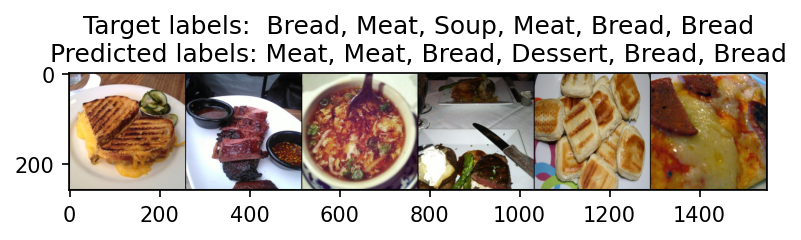

In [15]:
%matplotlib inline
mpl.rcParams['figure.dpi'] = 150

test_features, test_labels = next(iter(data_loader_test))
test_labels = test_labels.to(device)
test_features = dataset.getImgsTensors(test_features).to(device)

outputs = best_model(test_features)
outputs = torch.max(outputs, 1)[1]

plt.title('Target labels:  ' + ', '.join([dataset.getName(i) for i in test_labels[:6]]) + \
          '\nPredicted labels: ' + ', '.join([dataset.getName(i) for i in outputs[:6]]))
gridImgs = torchvision.utils.make_grid(test_features[:6]).cpu()
plt.imshow(cv2.cvtColor(gridImgs.permute(1, 2, 0).numpy() / 255, cv2.COLOR_BGR2RGB))
plt.show()